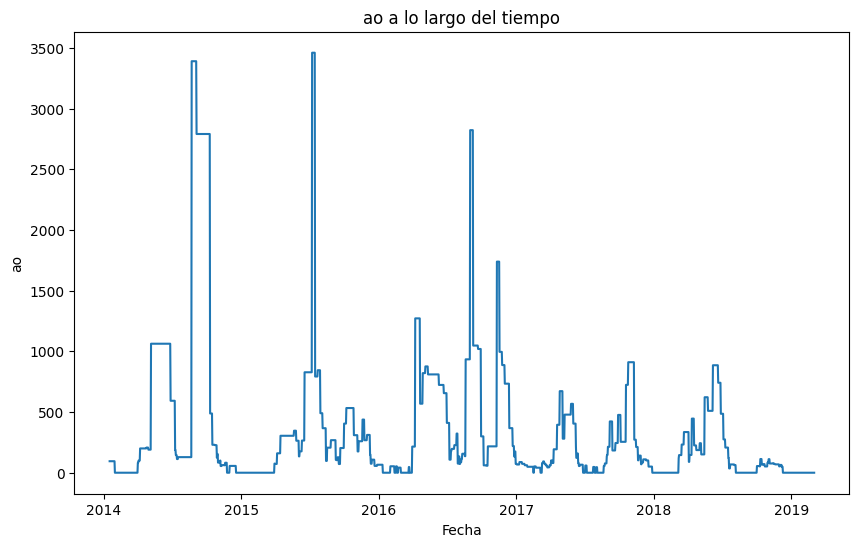

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Cargar el dataset
data = pd.read_csv('resultado1.csv')
data['fecha'] = pd.to_datetime(data['fecha'])
data.set_index('fecha', inplace=True)

# Visualizar los datos
plt.figure(figsize=(10, 6))
plt.plot(data['ao'])
plt.title('ao a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('ao')
plt.show()

# Preprocesamiento: Escalado de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['ao'].values.reshape(-1, 1))

# Crear conjuntos de entrenamiento y prueba
train_data = scaled_data.loc[:'2017-12-31']
test_data = scaled_data['2018-01-01':]

# Función para crear un dataset con ventanas de tiempo
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape de los datos para [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Desescalar las predicciones
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calcular RMSE y MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, test_predict))
mae = mean_absolute_error(y_test, test_predict)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Visualizar las predicciones
plt.figure(figsize=(10, 6))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(data.index[time_step:len(train_predict)+time_step], train_predict, label='Train Predict')
plt.plot(data.index[len(train_predict)+(time_step*2)+1:len(scaled_data)-1], test_predict, label='Test Predict')
plt.title('Predicciones usando LSTM')
plt.xlabel('Fecha')
plt.ylabel('ao')
plt.legend()
plt.show()
